In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import tomli
from scipy.optimize import curve_fit

In [2]:
def read_experiment_file(filename):
    metadata = {}
    data = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Parse metadata
    data_start = None
    for i, line in enumerate(lines):
        if line.strip() == "":
            continue
        
        parts = line.split('\t')
        if len(parts) == 2 and not parts[0].replace('.', '', 1).isdigit():
            key, value = parts
            metadata[key.strip()] = value.strip()
        elif "Current / A" in parts[0]:
            data_start = i + 1
            break
    
    # Read numerical data
    if data_start is not None:
        for line in lines[data_start:]:
            values = line.split('\t')
            if len(values) == 3:
                try:
                    data.append([float(v) for v in values])
                except ValueError:
                    continue  # Skip malformed lines
    
    df = pd.DataFrame(data, columns=["Current (A)", "Voltage (uV)", "Time (s)"])
    
    return metadata, df

In [3]:
# filename = "data/Ic_Data.txt"  # Change this to your actual file path
# metadata, df = read_experiment_file(filename)

# print("Metadata:", metadata)
# print("Data:")
# print(df.head())

In [4]:
# # Convert dataframe columns to NumPy arrays
# current = df["Current (A)"].to_numpy()
# voltage = df["Voltage (uV)"].to_numpy()
# time = df["Time (s)"].to_numpy()

# print(current[:5])  # Print first 5 values as a check
# print(voltage[:5])
# print(time[:5])

In [5]:
def sigmoid(x):
     return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x))) 

In [6]:
def discontinous(x,a,b,c,d,n):
    y = x-b
    return a*x+c + d*sigmoid(y/1)*np.abs(y)**np.clip(n, -10, 10)

In [154]:
def plot_voltage(cur, volt, savefig,name,ax=None):
    #p0 = [0.1, 64, -3, 0.001, 4]
    if ax is not None:
       ax = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    popt, pcov = curve_fit(discontinous, cur, volt,p0=p0,bounds=([0.01, 20, -3, 0, 3],[1, 70, 3, 0.01, 7]))
    print(popt)
    #print(popt)
    plt.plot(cur,volt)
    plt.plot(cur, discontinous(cur,*popt), label="Fitted Curve", color="blue")
    #plt.plot(cur, discontinous(cur,*p0), label="Fitted Curve", color="blue")
    plt.xlabel("Current")
    plt.ylabel("Voltage")
    if savefig:
        plt.savefig(os.getcwd() + "/" + name)
    return ax

[ 8.37275591e-02  4.81737546e+01 -2.43799121e+00  1.86655106e-09
  7.00000000e+00]


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

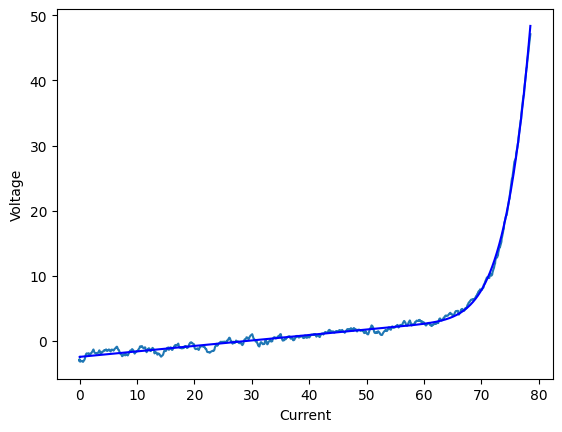

In [155]:
tesla_values = [0.025,0.05,0.1,0.2,0.3,0.4,0.5]
current_values = []
voltage_values  = []
for i, tesla in enumerate(tesla_values):
    metadata, df = read_experiment_file(f"data/Ic_Data_{tesla:.3g}T.txt")
    current = df["Current (A)"].to_numpy()
    voltage = df["Voltage (uV)"].to_numpy()
    current_values.append(current)
    voltage_values.append(voltage)

for i, tesla in enumerate(tesla_values):
    plot_voltage(current_values[i],voltage_values[i],0,"plot_1")
#plot_voltage(current_values[0],voltage_values[0],0,"plot_1")

